In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix

In [15]:
validation_comments = pd.read_csv('validation/Validation Comments - Sheet1.csv')
validation_comments = validation_comments.replace({'Label':{'Good': 1, 'Bad':0}})

prior_comments = pd.read_csv('files/compiled_comments_3_14_2021.csv')
prior_comments['Label'] = prior_comments['action']
prior_comments = prior_comments.drop(['action'], axis = 1)
prior_comments = prior_comments.replace({'Label': {False: 0, True: 1}})

In [16]:
train = validation_comments.sample(n = 212)
train = train.reset_index()

In [17]:
test = validation_comments.drop(train.index)
test = test.reset_index()

In [18]:
prior_test = prior_comments.sample(n = 2489)
prior_test = prior_test.reset_index()
prior_rest = prior_comments.drop(prior_test.index)
prior_rest = prior_comments.reset_index()

In [19]:
test = test.append(prior_test, ignore_index = True)

In [20]:
#'WordScore', 'adjWordScore', 'no_url_WordScore', 'WordScoreNoStop', 'no_url_or_stops_WordScore', 
x_train = train.drop('Label', axis = 1)
x_train = x_train[['WholeScore', 'contains_url','no_url_WholeScore',  'WholeScoreNoStop',
                   'no_url_or_stops_WholeScore', 'NER_count', 'NER_match', 'length', 'profanity']]
y_train = train['Label']

x_test = test.drop('Label', axis = 1)
x_test = x_test[['WholeScore', 'contains_url','no_url_WholeScore',  'WholeScoreNoStop',
                   'no_url_or_stops_WholeScore', 'NER_count', 'NER_match', 'length', 'profanity']]
y_test = test['Label']

x_unlabeled = prior_rest.drop('Label', axis = 1)
x_unlabeled = x_unlabeled[['WholeScore', 'contains_url','no_url_WholeScore',  'WholeScoreNoStop',
                   'no_url_or_stops_WholeScore', 'NER_count', 'NER_match', 'length', 'profanity']]

print(f"X_train dimensions: {x_train.shape}")
print(f"y_train dimensions: {y_train.shape}\n")

print(f"X_test dimensions: {x_test.shape}")
print(f"y_test dimensions: {y_test.shape}\n")

print(f"X_unlabeled dimensions: {x_unlabeled.shape}")

X_train dimensions: (212, 9)
y_train dimensions: (212,)

X_test dimensions: (2653, 9)
y_test dimensions: (2653,)

X_unlabeled dimensions: (10236, 9)


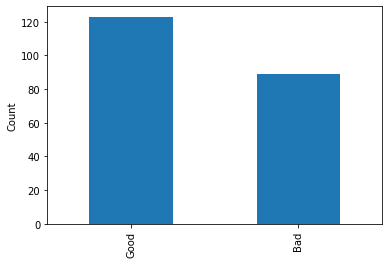

In [21]:
y_train.value_counts().plot(kind='bar')
plt.xticks([0,1], ['Good', 'Bad'])
plt.ylabel('Count');

# Initial model

Train f1 Score: 0.4126984126984127
Test f1 Score: 0.677068214804064


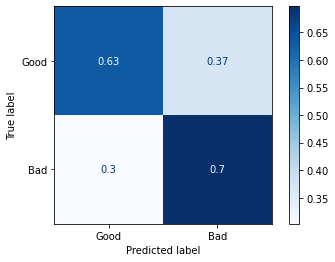

In [23]:
clf = LogisticRegression(max_iter=1000)

clf.fit(x_train, y_train)

y_hat_test = clf.predict(x_test)
y_hat_train = clf.predict(x_train)

train_f1 = f1_score(y_train, y_hat_train)
test_f1 = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

plot_confusion_matrix(clf, x_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['Good', 'Bad']);

# doing random forest

In [24]:
import pickle
import pandas as pd
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from compress_pickle import dump, load

Train f1 Score: 0.4126984126984127
Test f1 Score: 0.7992895204262876
Validation f1 Score: 0.5185185185185186


array([1, 1, 1, ..., 1, 1, 1])

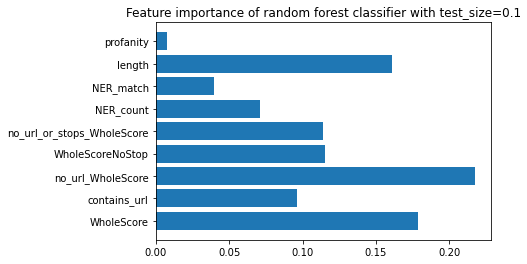

In [30]:
from sklearn.ensemble import RandomForestClassifier
#Random Forest Classifier
def random_forest_class_func(valid_df, prior_df, feature_list, target_name, test_size, estimators):
    #set up training and testing split
    valid_train = valid_df.sample(frac = 1 - test_size)
    prior_train = prior_df.sample(frac = 1 - test_size)
    
    valid_test = valid_df.drop(valid_train.index)
    prior_test = prior_df.drop(prior_train.index)
    
    train = valid_train.append(prior_train, ignore_index = True)
    test = valid_test.append(prior_test, ignore_index = True)
    
    X_train = train[feature_list]
    y_train = train[target_name]
    
    X_test = test[feature_list]
    y_test = test[target_name]
    
    valid_X_train = valid_train[feature_list]
    valid_y_train = valid_train[target_name]
    
    valid_X_test = valid_test[feature_list]
    valid_y_test = valid_test[target_name]
    
    #fit ridge classifier to x and y training set
    clf = RandomForestClassifier(n_estimators = estimators).fit(X_train, y_train)
    
    importances = clf.feature_importances_
    
    #Predict with ridge classifier on x and y testing set
    y_val = clf.predict(X_test)
    
    y_hat_test = clf.predict(X_test)
    y_hat_train = clf.predict(X_train)
    
    
    
    clf = RandomForestClassifier(n_estimators = estimators).fit(valid_X_train, valid_y_train)
    valid_y_hat_test = clf.predict(valid_X_test)
    
    #report the correct percentage of predictions
    test_f1 = f1_score(y_test, y_hat_test) 
    
    valid_f1 = f1_score(valid_y_test, valid_y_hat_test)
    print(f"Test f1 Score: {test_f1}")
    print(f"Validation f1 Score: {valid_f1}")
    
    #plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', normalize='true',
     #                display_labels=['Good', 'Bad']);
    
    plt.barh(feature_list, importances)
    plt.title('Feature importance of random forest classifier with test_size=' + str(test_size))
    
    return y_val

features = ['WholeScore', 'contains_url','no_url_WholeScore',  'WholeScoreNoStop',
                   'no_url_or_stops_WholeScore', 'NER_count', 'NER_match', 'length', 'profanity']
test = random_forest_class_func(validation_comments, prior_comments, features, 'Label', 0.1, 1000)
test